# Data Description

In the next workbook, we'll be calculating several values that will be important in helping our model identify trends in our data. These metrics are components of the total value of the sound present within each audio file. Reducing the sound into individual components will reduce the noise we have as input to our model.

Let's take a moment to explain what these values are and why they're important.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time
import os
import json

from sklearn.decomposition import PCA,TruncatedSVD

import librosa
import librosa.display
from scipy.stats import skew

##  Audio Metrics Description

From the Librosa Library, we imported several important metrics that will help our model distinguish between human speech and computer generated speech. I'd like to define what these metrics are and why I believe that they are important.

In [3]:
audio_file = 'datasets/somos/audios/LJ028-0146_027.wav'
y,sr = librosa.load(audio_file,sr=44100)
audio_data = librosa.effects.preemphasis(y, coef=0.97)

#### Mel-Frequency Cepstral Coefficients (MFCCs)

What they are: MFCCs stands for Mel-Frequency Cepstral Coefficients, which are a type of feature extraction technique commonly used in audio processing and machine learning applications. MFCCs are based on the human ear's perception of sound, and they represent the spectral envelope of a sound signal in a compressed form. They are used to extract important features from audio signals that can then be used in machine learning models to classify or recognize sound

What we're looking for: This metric provides us with the shape of an individual audio file. Within each audio file, it will be important to determine if the shape of computer generated speech is different than human speech.

For this metric, it's important to consider whether or not the data you're working with is highly correlated. Since we are working with speech data, we will assume that the data is highly correlated. This is because speech differs significantly from other audio signals in that it is:

1. Contextual and time dependent: 
    - The meaning of the second word is dependent on the first word)
2. Contains a mix of harmonic inharmonic components:
    - The human vocal tract produces sounds on a much wider spectrum than an instrument would
    - An instrument would produce a less variable output than the human vocal tract
    
As a result of these two complexities, it's likely our model will be highly susceptible to highly correlated features. We'll utilize MFCCs and opt to mean-normalize our data. This is en lieu of Mel-Scaled Filter banks and using the built in normalization feature.

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_48796/100386214.py:1: FutureWarning: Pass y=[-1.4034234e-04 -3.6114827e-05 -8.5668507e-06 ... -1.6058624e-02
  1.1397123e-02  2.4147606e-02], sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = (librosa.feature.mfcc(audio_data, sr, n_mels=40, n_fft=2048, hop_length=512, win_length=1024))


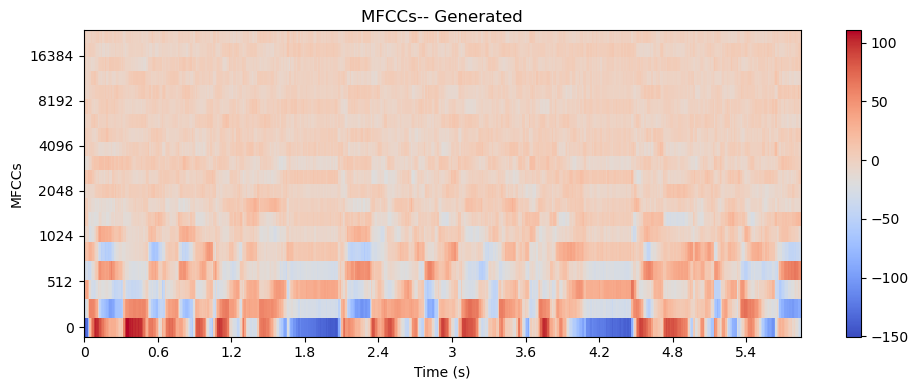

In [9]:
mfccs = (librosa.feature.mfcc(audio_data, sr, n_mels=40, n_fft=2048, hop_length=512, win_length=1024))
mfccs_mean = np.mean(mfccs, axis=1)
mfccs_norm = mfccs - mfccs_mean[:, np.newaxis]

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs_norm, x_axis="time", y_axis="mel", sr=sr)
plt.colorbar()
plt.title('MFCCs-- Generated')
plt.xlabel('Time (s)')
plt.ylabel('MFCCs')
plt.tight_layout()
plt.show()

Above is a representation of a computer generation audio clip. We'll do the same below for a human utterance using the same UtteranceId (sentence).

In [4]:
audio_file_human = 'datasets/somos/audios/gt_LJ028-0146_000.wav'
y,sr = librosa.load(audio_file_human,sr=44100)
audio_data_human = librosa.effects.preemphasis(y, coef=0.97)

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_38391/2635462245.py:1: FutureWarning: Pass y=[-1.6197322e-05 -1.7232768e-04 -2.4186971e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00], sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = (librosa.feature.mfcc(audio_data_human, sr, n_mels=40, n_fft=2048, hop_length=512, win_length=1024))


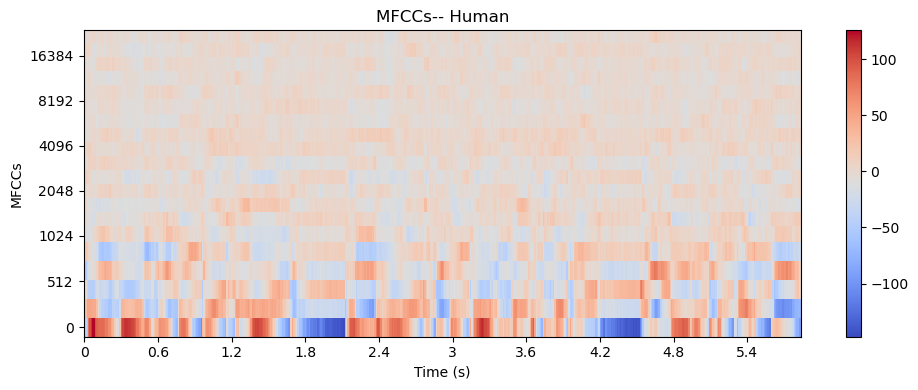

In [5]:
mfccs = (librosa.feature.mfcc(audio_data_human, sr, n_mels=40, n_fft=2048, hop_length=512, win_length=1024))
mfccs_norm = mfccs - mfccs_mean[:, np.newaxis]

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs_norm, x_axis="time", y_axis="mel", sr=sr)
plt.colorbar()
plt.title('MFCCs-- Human')
plt.xlabel('Time (s)')
plt.ylabel('MFCCs')
plt.tight_layout()
plt.show()

As you can see, There are differences between the human audio and the computer generated audio. This audio was generated using the same data between the human version and the computer version, but they produced a slightly different shape

In [6]:
mfccs

array([[-4.2201187e+02, -3.1986407e+02, -2.4452950e+02, ...,
        -3.5772800e+02, -3.5812149e+02, -3.7315530e+02],
       [ 6.2847080e+00,  6.7358047e+01,  9.0691963e+01, ...,
        -3.4384098e+01, -2.9204613e+01, -3.0843273e+01],
       [-6.9043894e+00, -3.2936005e+01, -6.1062099e+01, ...,
        -7.4193902e+00, -4.3105521e+00, -2.1378340e+01],
       ...,
       [ 1.6711780e+00, -3.6436408e+00, -8.2027855e+00, ...,
         3.4429040e+00, -5.2821064e-01,  2.0062351e+00],
       [ 5.3152580e+00, -8.9702749e-01,  9.0142894e-01, ...,
        -5.0975118e+00, -3.1398482e+00, -1.0619760e-02],
       [ 2.3195717e+00, -4.4828944e+00, -2.5321145e+00, ...,
         9.8784828e-01,  1.7954540e-01, -3.5451341e+00]], dtype=float32)

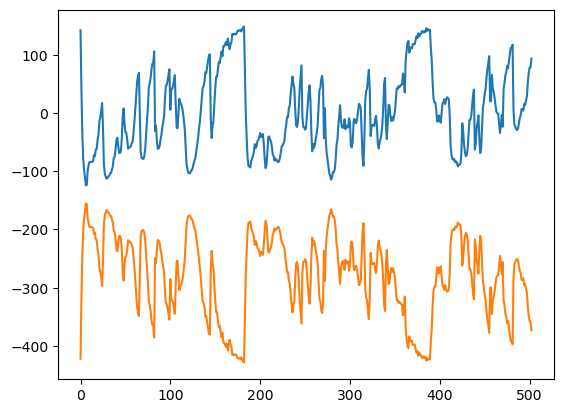

In [7]:
X = mfccs[0].reshape(-1,1)
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
plt.plot(X_pca)
plt.plot(mfccs[0]);

#### Spectral Centroids

Spectral centroids can tell us about the "brightness" or "darkness" of a sound in a particular frequency range. In the case of voice data, we can use spectral centroids to analyze the characteristics of a speaker's voice. For example, a high spectral centroid could indicate that a speaker has a "brighter" voice with more high-frequency components, while a low spectral centroid could indicate a "darker" voice with more low-frequency components. 

Additionally, we can track changes in the spectral centroid over time to analyze how a speaker's voice changes or how their tone and emotion fluctuate throughout a conversation. Overall, spectral centroids can provide valuable insights into the characteristics and qualities of a speaker's voice, which can be useful for tasks such as speaker identification, emotion recognition, and speech analysis.

Once again, we'll calculate these values for the generated audio and then again for the human audio

In [8]:
audio_file = 'datasets/somos/audios/LJ028-0146_027.wav'
y,sr = librosa.load(audio_file,sr=44100)
audio_data = librosa.effects.preemphasis(y, coef=0.97)
np.isnan(audio_data).any()

False

In [9]:
spectral_centroids = librosa.feature.spectral_centroid(audio_data, sr = 44100)

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_6225/2789601883.py:1: FutureWarning: Pass y=[-1.4034234e-04 -3.6114827e-05 -8.5668507e-06 ... -1.6058624e-02
  1.1397123e-02  2.4147606e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio_data, sr = 44100)


In [10]:
audio_file_human = 'datasets/somos/audios/gt_LJ028-0146_000.wav'
y,sr = librosa.load(audio_file_human,sr=44100)
audio_data_human = librosa.effects.preemphasis(y, coef=0.97)

In [11]:
spectral_centroids_human = librosa.feature.spectral_centroid(audio_data_human, sr = 44100)

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_6225/1692407422.py:1: FutureWarning: Pass y=[-1.6197322e-05 -1.7232768e-04 -2.4186971e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids_human = librosa.feature.spectral_centroid(audio_data_human, sr = 44100)


/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_6225/1291538221.py:6: FutureWarning: Pass y=[-1.4034234e-04 -3.6114827e-05 -8.5668507e-06 ... -1.6058624e-02
  1.1397123e-02  2.4147606e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio_data)[:,:spectral_centroids_human.shape[1]]


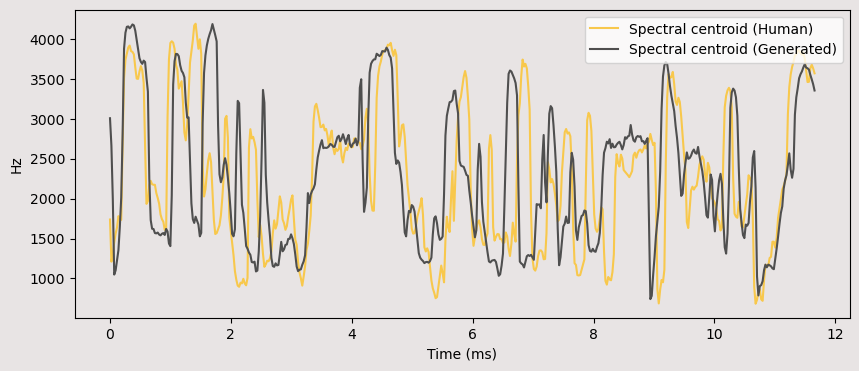

In [23]:
yellow = '#f8c84c'
grey = '#4F4F4F'
background = '#e8e4e4'

times = librosa.times_like(spectral_centroids_human)
spectral_centroids = librosa.feature.spectral_centroid(audio_data)[:,:spectral_centroids_human.shape[1]]

# Set the figure size and background color
plt.figure(figsize=(10, 4), facecolor=background)

# Create the plot with the yellow-gray color scheme
ax = plt.gca()
ax.plot(times, spectral_centroids_human.T, color=yellow, label='Spectral centroid (Human)')
ax.plot(times, spectral_centroids.T, color=grey, label='Spectral centroid (Generated)')
ax.set_ylabel('Hz')
ax.set_xlabel('Time (ms)')
ax.legend()
ax.set_facecolor(background)

In [15]:
len(spectral_centroids[0])

504

Given the same sentence, both the human and computer generated audio produced a similar spectrogram. This is a reasonable result as the spectral centroids tell us 'how' a sentence is said. The higher the spectral value, the brighter the tone; the lower, the darker the tone. The fluctuations in the graph indicate the natural fluctuations of speech. It's expected that the spectrogram will vary from person to person for the same sentence, so it's not unexpected to have a similar result.

Over a series of calculations for this result, it is possible that there are trends within the differences in computer vs. Human speech that we do not see within this single graph.

In [16]:
X = spectral_centroids_human[0].reshape(-1,1)
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
len(X_pca)

503

#### Spectral Bandwidth

In the context of speech, spectral bandwidth can provide information about the overall spectral content of a speech signal. Specifically, it gives us an idea of how wide the frequency range of the speech signal is at any given time, which can be useful for various speech processing tasks such as speech recognition, speaker identification, and emotion recognition. 

For example, changes in spectral bandwidth over time can indicate changes in the vocal tract shape and size, which can be indicative of changes in speech style or emotional state. Additionally, spectral bandwidth can be used as a feature for speech recognition, where different phonemes are known to have different bandwidth characteristics.

In [17]:
audio_file = 'datasets/somos/audios/LJ028-0146_027.wav'
y,sr = librosa.load(audio_file,sr=44100)
audio_data = librosa.effects.preemphasis(y, coef=0.97)

In [18]:
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)

In [19]:
audio_file_human = 'datasets/somos/audios/gt_LJ028-0146_000.wav'
y,sr = librosa.load(audio_file_human,sr=44100)
audio_data_human = librosa.effects.preemphasis(y, coef=0.97)
S = np.abs(librosa.stft(y))

In [20]:
spectral_bandwidth_human = librosa.feature.spectral_bandwidth(y=y, sr=sr)

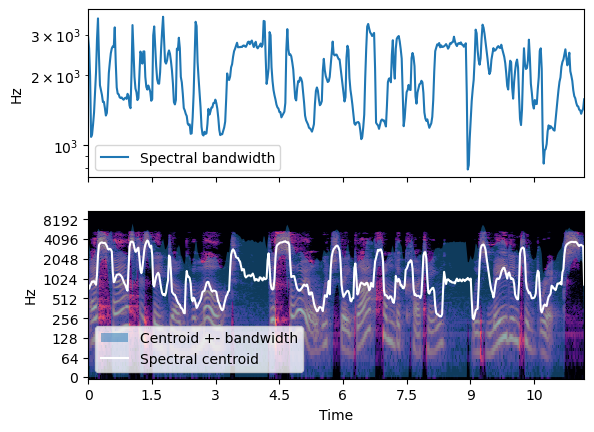

In [21]:
fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(spectral_bandwidth)
centroid = librosa.feature.spectral_centroid(S=S)
ax[0].semilogy(times, spectral_bandwidth[0], label='Spectral bandwidth')
ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])

centroid_resized = np.resize(centroid[0], spectral_bandwidth[0].shape)
spectral_bandwidth_resized = np.resize(spectral_bandwidth[0,:len(centroid.T)], centroid_resized.shape)

# Fill the area between the bandwidth and the centroid line
ax[1].fill_between(times, np.maximum(0, centroid_resized - spectral_bandwidth_resized),
                np.minimum(centroid_resized + spectral_bandwidth_resized, sr/2),
                alpha=0.5, label='Centroid +- bandwidth')

ax[1].plot(times, centroid_resized, label='Spectral centroid', color='w');
ax[1].legend(loc='lower left')

Because the clips are so short, the full effect of change in timbre is likely to not be seen within this plot. As a person speaks, the timbre of their voice varies as they project emotion in their voices or change their tone. With sentences that are typically less than 10 seconds, this feature will likely not be able to show significant results immediately.

Similar to the spectral centroids, it's likely that the variance within each plot will yield the biggest difference. As we can see in the above plot, the fluctuations are similar, however there are observable differences in the local highs and lows.

#### Spectral Contrast

Spectral contrast is a method for analyzing the spectral content of audio signals. It measures the difference in magnitude between peaks and valleys in the frequency spectrum of an audio signal. The spectral contrast is computed by dividing the frequency spectrum into a number of sub-bands and comparing the mean magnitudes of the peaks and valleys within each sub-band.

While spectral centroid and bandwidth describe the center and spread of the frequency content of a signal, spectral contrast measures the differences between spectral peaks and valleys in each frequency band. In other words, spectral contrast measures how much a given frequency bin differs from its surrounding bins in terms of magnitude.

Spectral contrast is often used in speech recognition and music genre classification tasks, as it can provide information about the relative prominence of different frequency components in a signal, and how they contribute to the overall perceptual qualities of the signal.

In [22]:
audio_file = 'datasets/somos/audios/LJ028-0146_027.wav'
y,sr = librosa.load(audio_file,sr=44100)
audio_data = librosa.effects.preemphasis(y, coef=0.97)
duration = librosa.get_duration(y=y, sr=sr)

In [23]:
spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

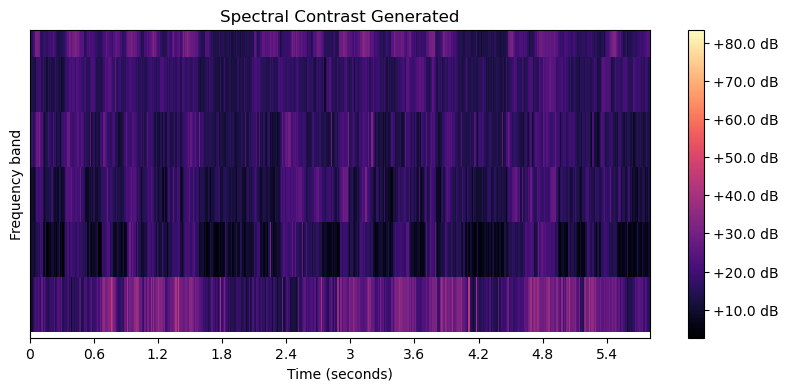

In [24]:
# Compute spectral contrast and spectral centroid
spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)

# Plot the spectral contrast
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectral_contrast, x_axis='time', sr=sr, hop_length= 512)
plt.colorbar(format='%+0.1f dB')
plt.title('Spectral Contrast Generated')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency band')
plt.xlim(0,5.8)
plt.ylim(-.6,5)

# Overlay the spectral centroid
plt.plot(librosa.times_like(spectral_centroids), spectral_centroids[0], color='w', linewidth=2)
plt.show()

In [25]:
audio_file_human = 'datasets/somos/audios/gt_LJ028-0146_000.wav'
y,sr = librosa.load(audio_file_human,sr=44100)
audio_data_human = librosa.effects.preemphasis(y, coef=0.97)
S = np.abs(librosa.stft(y))

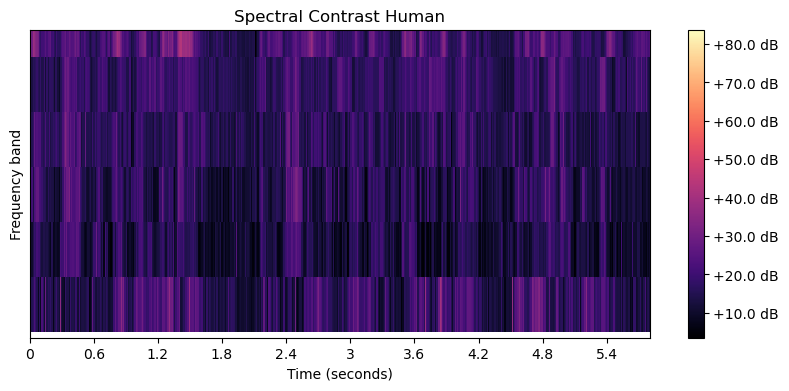

In [26]:
# Compute spectral contrast and spectral centroid
spectral_contrast_human = librosa.feature.spectral_contrast(y=y, sr=sr)
spectral_centroids_human = librosa.feature.spectral_centroid(y=y, sr=sr)

# Plot the spectral contrast
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectral_contrast_human, x_axis='time', sr=sr, hop_length= 512)
plt.colorbar(format='%+0.1f dB')
plt.title('Spectral Contrast Human')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency band')
plt.xlim(0,5.8)
plt.ylim(-.6,5)

# Overlay the spectral centroid
plt.plot(librosa.times_like(spectral_centroids_human), spectral_centroids_human[0], color='w', linewidth=2)
plt.show()

#### Zero Crossing Rate

In speech analysis, zero crossing rate refers to the rate at which the speech signal changes from positive to negative or vice versa. It is a measure of the frequency content of a speech signal, and is related to the pitch and the vocal timbre of the speaker. High zero crossing rate generally indicates high-frequency content in the speech signal, while low zero crossing rate indicates low-frequency content. Zero crossing rate can be used as a feature in speech recognition and speaker identification systems.

In [39]:
audio_file = 'datasets/somos/audios/LJ028-0146_027.wav'
y,sr = librosa.load(audio_file,sr=44100)
audio_data = librosa.effects.preemphasis(y, coef=0.97)
duration = librosa.get_duration(y=y, sr=sr)

In [40]:
zero_crossing_rate = librosa.feature.zero_crossing_rate(audio_data)

In [41]:
audio_file_human = 'datasets/somos/audios/gt_LJ028-0146_000.wav'
y,sr = librosa.load(audio_file_human,sr=44100)
audio_data_human = librosa.effects.preemphasis(y, coef=0.97)
S = np.abs(librosa.stft(y))

In [42]:
zero_crossing_rate_human = librosa.feature.zero_crossing_rate(audio_data_human)

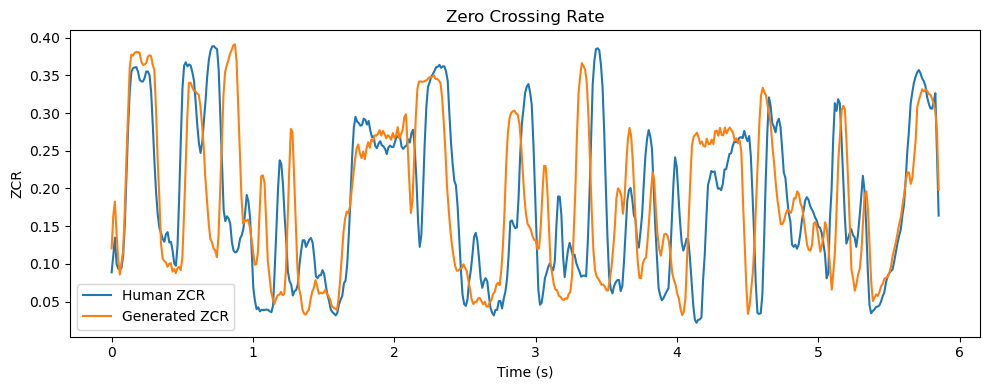

In [43]:
t_human = np.linspace(0, duration, num=zero_crossing_rate_human.shape[1])
t_gen = np.linspace(0, duration, num=zero_crossing_rate.shape[1])

plt.figure(figsize=(10, 4))
plt.plot(t_human, zero_crossing_rate_human[0], label='Human ZCR')
plt.plot(t_gen, zero_crossing_rate[0], label='Generated ZCR')
plt.title('Zero Crossing Rate')
plt.xlabel('Time (s)')
plt.ylabel('ZCR')
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
zero_crossing_rate_human.min(), zero_crossing_rate_human.max(), zero_crossing_rate_human.mean()

(0.02197265625, 0.388671875, 0.18173090364065606)

The results from both calculations do not yield significant visible results in the two plots. We'll see if this feature is important later in the analysis

#### Chroma

In voice recognition, Chroma is a feature that helps to identify and distinguish between different notes and pitches in a person's voice. By analyzing the frequency spectrum of a voice signal and mapping it onto a musical scale, Chroma can provide a representation of the harmonic content of a person's voice. This information can be useful for tasks such as speaker identification and music transcription, where it is important to accurately capture the nuances of a person's vocal performance. 

Additionally, since Chroma captures information about the underlying musical structure of a voice signal, it can be used to identify patterns and trends in a person's vocal behavior, which may be useful for studying speech and language development or identifying vocal disorders.

In [45]:
audio_file = 'datasets/somos/audios/LJ028-0146_027.wav'
y,sr = librosa.load(audio_file,sr=44100)
audio_data = librosa.effects.preemphasis(y, coef=0.97)
duration = librosa.get_duration(y=y, sr=sr)

In [46]:
chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)

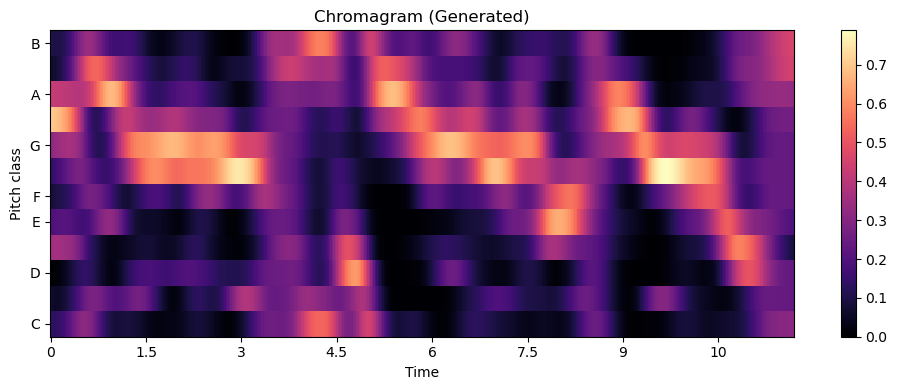

In [47]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram (Generated)')
plt.tight_layout()
plt.show()

In [48]:
audio_file_human = 'datasets/somos/audios/gt_LJ028-0146_000.wav'
y,sr = librosa.load(audio_file_human,sr=44100)
audio_data_human = librosa.effects.preemphasis(y, coef=0.97)
S = np.abs(librosa.stft(y))

In [49]:
chroma_cens_human = librosa.feature.chroma_cens(y=y, sr=sr)

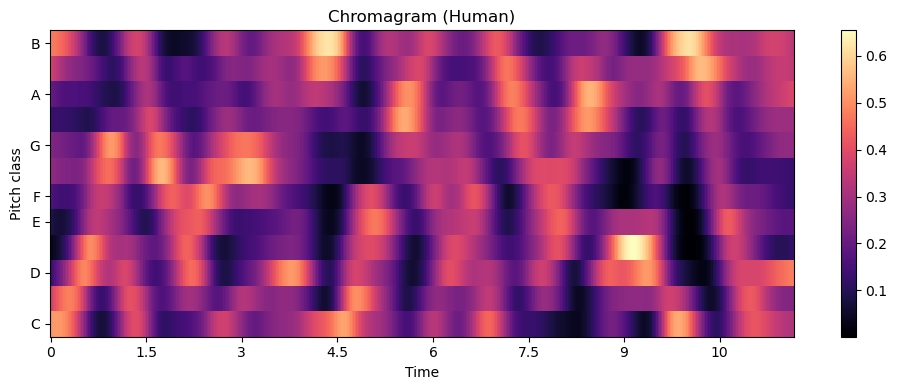

In [50]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma_cens_human, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram (Human)')
plt.tight_layout()
plt.show()

This plot shows a significant difference between the generated and human iterations of the same sentence. Each horizontal bar represents a specific pitch class (note). As we move through the plot, from left to right, we see how that note changes within the audio signal.

Within the human audio signal, we see a very clear path from one note to the next. In the generated audio, we do not see this same clear trend.

## Root Mean Squared

Before we process our data, we want all of our audio to be normalized against the root mean squared amplitude. This is a measure of the energy in each audio signal, which we can interpret as loudness or volume.

In [51]:
audio_file = 'datasets/somos/audios/LJ028-0146_027.wav'

In [52]:
y, sr = librosa.load(audio_file)
rms = librosa.feature.rms(y=y)[0]
maxrms,minrms = max(rms),min(rms)
maxrms,minrms

(0.20066506, 0.0006509096)

In [53]:
audio_file_human = 'datasets/somos/audios/gt_LJ028-0146_000.wav'

In [54]:
y, sr = librosa.load(audio_file_human)
rms = librosa.feature.rms(y=y)[0]
maxrms,minrms = max(rms),min(rms)
maxrms,minrms

(0.2344249, 0.00072899123)

### Additional Data

Now we'll use what we found above to import additional data. We'll use the Librosa Library, which will be introduced in the next sheet.